In [118]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [119]:
data = pd.read_csv('./data_processed/shopInfo美食_food_price_processed.csv', header=0, na_values=['NULL','','null','-'])
data.describe()

,shopId,shopGlng,shopPower,shopType,price,comNum
count,2.929800e+04,29298.000000,29287.000000,29285.000000,18424.000000,28695.000000
mean,4.151961e+07,121.948665,32.893482,12.231893,83.833587,398.560725
std,2.922435e+07,44.148984,14.063756,128.375264,370.799119,1397.330148
min,5.000000e+05,12.000000,0.000000,6.000000,0.000000,0.000000
25%,1.561258e+07,121.386320,30.000000,10.000000,20.000000,2.000000
50%,3.812097e+07,121.450310,35.000000,10.000000,40.000000,19.000000
75%,6.826360e+07,121.499390,35.000000,10.000000,81.000000,181.000000
max,9.238334e+07,6162.000000,1416.000000,16023.000000,20713.000000,38201.000000


In [120]:
data.shape

(29298, 12)

In [121]:
data.dtypes

shopId                int64
shopName             object
shopGlat             object
shopGlng            float64
shopPower           float64
shopType            float64
mainCategoryName     object
categoryURLName      object
shopGroupId          object
categoryName         object
price               float64
comNum              float64
dtype: object

In [122]:
data.head()

,shopId,shopName,shopGlat,shopGlng,shopPower,shopType,mainCategoryName,categoryURLName,shopGroupId,categoryName,price,comNum
0,10005888,上外贸一食堂,31.049650000057,121.214940,35.0,10.0,快餐简餐,food,10005888,美食,13.0,8.0
1,10005965,Mr.Pizza米斯特比萨,31.225962,121.559517,40.0,10.0,比萨,food,6264064,美食,79.0,1101.0
2,10008090,香三荷精致中式快餐,31.00489,121.232610,35.0,10.0,快餐简餐,food,10008090,美食,13.0,8.0
3,10008096,Chaumont,31.228377,121.518376,35.0,10.0,西式甜点,food,6009314,美食,119.0,23.0
4,10008863,塔顶泰国时尚餐厅,31.156886,121.516042,45.0,10.0,泰国菜,food,4523171,美食,153.0,2937.0


In [123]:
#missing data
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
price,10874,0.371152
comNum,603,0.020582
categoryName,267,0.009113
shopGroupId,176,0.006007
categoryURLName,95,0.003243
mainCategoryName,38,0.001297
shopType,13,0.000444
shopPower,11,0.000375
shopGlat,1,0.000034
shopGlng,0,0.000000


price数据中，有很多点没有给出人均价格，而且这样的店有很多，不能够直接将其删除。因此，使用0填充这部分值，构建向量的时候，周围店的平均价格，值为0的店不加入计算。

In [124]:
data['price'].fillna(0, inplace=True)
data['price'].isnull().sum()

0

categoryName和categoryURLName对美食这一类都是一样的，而且有不少缺失数据，因此删除这个特征

In [230]:
df_train = data.copy()

In [231]:
df_train.drop(['categoryName','categoryURLName'], axis=1, inplace=True)

In [232]:
df_train.dropna(inplace=True)

In [233]:
df_train.shopGlat = df_train.shopGlat.astype('float')
df_train.shape

(28695, 11)

In [234]:
ulimit = np.percentile(df_train.shopGlat.values, 99)
llimit = np.percentile(df_train.shopGlat.values, 1)
lat_illegal1 = df_train['shopGlat'] > ulimit
lat_illegal2 = df_train['shopGlat'] < llimit

ulimit = np.percentile(df_train.shopGlng.values, 99)
llimit = np.percentile(df_train.shopGlng.values, 1)
lng_illegal1 = df_train['shopGlng'] > ulimit
lng_illegal2 = df_train['shopGlng'] < llimit

df_train.drop(df_train.index[lng_illegal1 | lat_illegal1 | lng_illegal2 | lat_illegal2], inplace=True)
print(lat_illegal1.shape, lat_illegal2.shape, lng_illegal1.shape, lng_illegal2.shape)

(28695,) (28695,) (28695,) (28695,)


In [235]:
# ulimit = np.percentile(df_train.shopGlat.values, 99)
# df_train['shopGlat'] > ulimit

# 读入灯光中心，转换距离

In [236]:
light_centers = pd.read_csv('./data_processed/light_centers.csv')

In [237]:
from math import radians, cos, sin, asin, sqrt
def geodistance(lng1, lat1, lng2, lat2):
#     print(lng1, lat1, lng2, lat2)
    lng1, lat1, lng2, lat2 = map(radians, [lng1, lat1, lng2, lat2])
    dlon = lng2 - lng1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    dis = 2 * asin(sqrt(a)) * 6371
    return dis

In [238]:
dist_metrics = np.zeros((data.shape[0], len(light_centers)))
centers = light_centers

for index in range(len(centers)):
#     dist_lng = np.square(data['shopGlng'] - centers[index][0])
#     dist_lat = np.square(data['shopGlat']-centers[index][1])
    for j in range(df_train.shape[0]):
        dist_metrics[j,index] = geodistance(df_train.iloc[j,3], df_train.iloc[j,2], centers.iloc[index, 0], centers.iloc[index, 1])
    if index % 10 ==0:
        print("process %d" %index)
#     print(data.iloc[0,2],centers[index][0])


dist_vec = dist_metrics.min(axis=1)
dist_vec = pd.Series(dist_vec)
# data.drop(['shopGlat','shopGlng'], axis=1, inplace=True)
df_train['dist_to_center'] = dist_vec
df_train['dist_to_center'].describe()

process 0
process 10
process 20


count    27548.000000
mean         3.768169
std          2.941925
min          0.000000
25%          1.912314
50%          3.250387
75%          4.915251
max         23.466470
Name: dist_to_center, dtype: float64

In [239]:
df_train.head()

,shopId,shopName,shopGlat,shopGlng,shopPower,shopType,mainCategoryName,shopGroupId,price,comNum,dist_to_center
0,10005888,上外贸一食堂,31.049650,121.214940,35.0,10.0,快餐简餐,10005888,13.0,8.0,1.249652
1,10005965,Mr.Pizza米斯特比萨,31.225962,121.559517,40.0,10.0,比萨,6264064,79.0,1101.0,3.008027
2,10008090,香三荷精致中式快餐,31.004890,121.232610,35.0,10.0,快餐简餐,10008090,13.0,8.0,4.014401
3,10008096,Chaumont,31.228377,121.518376,35.0,10.0,西式甜点,6009314,119.0,23.0,3.301536
4,10008863,塔顶泰国时尚餐厅,31.156886,121.516042,45.0,10.0,泰国菜,4523171,153.0,2937.0,2.297211


# 周围店的信息

画格子，讲所有店放入不同的格子

In [240]:
other_shops = pd.read_csv('./data_processed/all_data.csv', header=0, na_values=['NULL','','null'])
other_shops.apply(lambda x:sum(x.isnull())), other_shops.shape

(shopId                30
 shopName              51
 shopGlng             504
 shopGlat             503
 shopPower           9022
 shopType            9059
 mainCategoryName    9117
 categoryURLName     9175
 shopGroupId         8851
 categoryName        9506
 comNum               411
 dtype: int64, (73531, 11))

In [241]:
other_shops.dropna(inplace=True)
other_shops.shape

(64007, 11)

删除异常的经纬度坐标

In [242]:
lng_illegal = other_shops['shopGlng'] < 120 
lng_illegal2 = other_shops['shopGlng'] > 122
lat_illegal = other_shops['shopGlat'] < 30 
lat_illegal2 = other_shops['shopGlat'] > 32
# shop_power_illegal = other_shops['shopPower'] == 0
other_shops.drop(other_shops.index[lng_illegal | lat_illegal | lng_illegal2 | lat_illegal2], inplace=True)
other_shops.shape, sum(lng_illegal | lat_illegal | lng_illegal2 | lat_illegal2)

((63969, 11), 38)

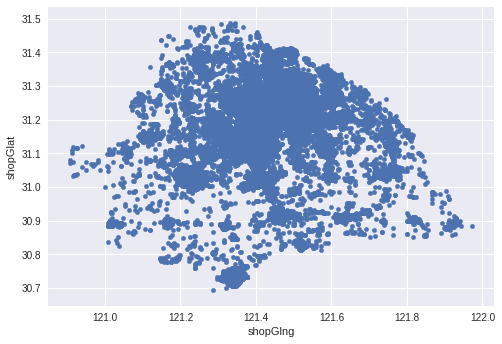

In [243]:
lnglat = other_shops[['shopGlng', 'shopGlat']]
lnglat.plot(x='shopGlng', y='shopGlat', kind='scatter')

In [244]:
from Block import Block

In [245]:
other_shops.head()

,shopId,shopName,shopGlng,shopGlat,shopPower,shopType,mainCategoryName,categoryURLName,shopGroupId,categoryName,comNum
0,11547695.0,上海天地汇商务会所,121.476019,31.222743,40.0,15.0,会所型KTV,KTV,11547695.0,K歌,31.0
1,11558194.0,伯爵3号私享会所,121.507335,31.217015,45.0,15.0,会所型KTV,KTV,11558194.0,K歌,42.0
3,12215356.0,歌巢量贩KTV,121.347418,31.415469,40.0,15.0,量贩式KTV,KTV,12215356.0,K歌,103.0
4,12595312.0,富建娱乐会所,121.360637,31.138041,35.0,15.0,会所型KTV,KTV,12595312.0,K歌,9.0
5,13706336.0,K1时尚量贩KTV,121.485070,31.206350,40.0,15.0,量贩式KTV,KTV,13706336.0,K歌,319.0


In [246]:
food_shops = df_train[['shopId','shopName','shopGlng','shopGlat','shopPower','shopType','shopGroupId', 'comNum', 'price']].copy()
food_shops.head()

,shopId,shopName,shopGlng,shopGlat,shopPower,shopType,shopGroupId,comNum,price
0,10005888,上外贸一食堂,121.214940,31.049650,35.0,10.0,10005888,8.0,13.0
1,10005965,Mr.Pizza米斯特比萨,121.559517,31.225962,40.0,10.0,6264064,1101.0,79.0
2,10008090,香三荷精致中式快餐,121.232610,31.004890,35.0,10.0,10008090,8.0,13.0
3,10008096,Chaumont,121.518376,31.228377,35.0,10.0,6009314,23.0,119.0
4,10008863,塔顶泰国时尚餐厅,121.516042,31.156886,45.0,10.0,4523171,2937.0,153.0


In [247]:
other_shops_copy = other_shops.copy()
other_shops_copy.drop(['mainCategoryName','categoryURLName','categoryName'], axis=1, inplace=True)
other_shops_copy['price'] = 0
other_shops_copy.head()

,shopId,shopName,shopGlng,shopGlat,shopPower,shopType,shopGroupId,comNum,price
0,11547695.0,上海天地汇商务会所,121.476019,31.222743,40.0,15.0,11547695.0,31.0,0
1,11558194.0,伯爵3号私享会所,121.507335,31.217015,45.0,15.0,11558194.0,42.0,0
3,12215356.0,歌巢量贩KTV,121.347418,31.415469,40.0,15.0,12215356.0,103.0,0
4,12595312.0,富建娱乐会所,121.360637,31.138041,35.0,15.0,12595312.0,9.0,0
5,13706336.0,K1时尚量贩KTV,121.485070,31.206350,40.0,15.0,13706336.0,319.0,0


In [248]:
all_shops = pd.concat((food_shops, other_shops_copy))
all_shops.shape

(91517, 9)

In [249]:
all_shops.head()

,shopId,shopName,shopGlng,shopGlat,shopPower,shopType,shopGroupId,comNum,price
0,10005888.0,上外贸一食堂,121.214940,31.049650,35.0,10.0,10005888,8.0,13.0
1,10005965.0,Mr.Pizza米斯特比萨,121.559517,31.225962,40.0,10.0,6264064,1101.0,79.0
2,10008090.0,香三荷精致中式快餐,121.232610,31.004890,35.0,10.0,10008090,8.0,13.0
3,10008096.0,Chaumont,121.518376,31.228377,35.0,10.0,6009314,23.0,119.0
4,10008863.0,塔顶泰国时尚餐厅,121.516042,31.156886,45.0,10.0,4523171,2937.0,153.0


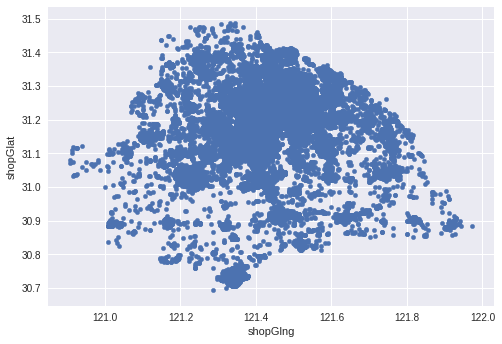

In [250]:
all_shops.plot(x='shopGlng', y='shopGlat', kind='scatter')

In [253]:
all_shops.to_csv('./tmp_data/all.csv', index=False)

In [259]:
all_shops = pd.read_csv('./tmp_data/all.csv')

In [263]:
from Block import Block

In [264]:
block = Block(all_shops)
block.divide_square()

0 28 44
1000 50 77
2000 59 79
3000 54 73
4000 32 39
5000 51 30
6000 51 79
7000 51 65
8000 59 73
9000 56 55
10000 27 40
11000 63 81
12000 34 59
13000 65 74
14000 31 45
15000 54 80
16000 24 84
17000 42 66
18000 70 56
19000 56 48
20000 78 60
21000 26 62
22000 58 71
23000 51 61
24000 53 72
25000 62 82
26000 43 61
27000 56 63
28000 51 73
29000 48 75
30000 58 68
31000 53 26
32000 58 65
33000 30 67
34000 62 55
35000 59 67
36000 44 94
37000 54 67
38000 50 64
39000 52 65
40000 28 42
41000 27 40
42000 44 50
43000 18 57
44000 48 56
45000 64 71
46000 52 68
47000 57 67
48000 66 62
49000 38 24
50000 62 58
51000 63 70
52000 62 69
53000 69 47
54000 26 44
55000 38 54
56000 49 66
57000 40 57
58000 55 71
59000 42 65
60000 38 57
61000 48 68
62000 36 59
63000 54 65
64000 50 30
65000 56 63
66000 56 73
67000 63 41
68000 79 44
69000 45 45
70000 30 39
71000 53 69
72000 33 52
73000 86 25
74000 40 2
75000 43 62
76000 55 57
77000 44 69
78000 54 61
79000 51 69
80000 24 83
81000 86 25
82000 37 54
83000 52 28
84000 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [270]:
shops = block.get_square(121.3,31.2)
len(shops)

34

In [272]:
comments = []
scores = []
prices = []
num = 0
for u in food_shops.index:
    if num % 1000 == 0:
        print(num)
    num += 1
    lng = food_shops.loc[u].shopGlng
    lat = food_shops.loc[u].shopGlat
    shops = block.get_square(lng, lat)
    sumc = 0
    sums = 0
    sump = 0
    n = 0
    np = 0
    for s in shops:
        if s.shopId == food_shops.loc[u].shopId:
            continue
        sumc += s.comNum
        sums += s.shopPower
        if s.price!=0:
            np+=1
            sump += s.price
        n += 1
    if n == 0:
        n=1
    if np == 0:
        np = 1
    comments.append(sumc/n)
    scores.append(sums/n)
    prices.append(sump/np)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000


In [273]:
food_shops['other_comments'] = comments
food_shops['other_scores'] = scores
food_shops['other_prices'] = prices

In [274]:
food_shops.head()

,shopId,shopName,shopGlng,shopGlat,shopPower,shopType,shopGroupId,comNum,price,other_comments,other_scores,other_prices
0,10005888,上外贸一食堂,121.214940,31.049650,35.0,10.0,10005888,8.0,13.0,46.262774,31.423358,24.466667
1,10005965,Mr.Pizza米斯特比萨,121.559517,31.225962,40.0,10.0,6264064,1101.0,79.0,626.598039,37.254902,95.931818
2,10008090,香三荷精致中式快餐,121.232610,31.004890,35.0,10.0,10008090,8.0,13.0,64.652542,25.805085,38.050000
3,10008096,Chaumont,121.518376,31.228377,35.0,10.0,6009314,23.0,119.0,585.845440,35.965997,73.093596
4,10008863,塔顶泰国时尚餐厅,121.516042,31.156886,45.0,10.0,4523171,2937.0,153.0,88.090909,28.636364,48.250000


# one-hot编码

In [275]:
percent = df_train['mainCategoryName'].value_counts()/df_train.shape[0]

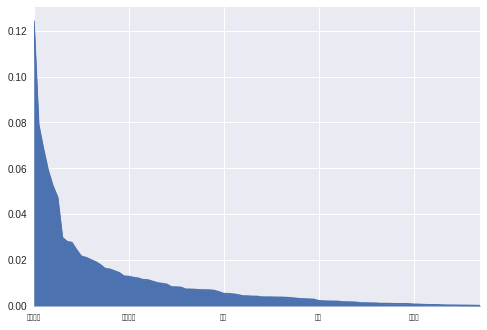

In [276]:
percent.plot.area()

In [277]:
sum(percent[:40])

0.89167997676782351

In [278]:
dummy_list = percent[:41].index
df_train.loc[df_train['mainCategoryName'].apply(lambda x: x not in dummy_list), 'mainCategoryName'] = '其他'

In [279]:
df_train['mainCategoryName']

0            快餐简餐
1              比萨
2            快餐简餐
3            西式甜点
4              其他
5              小吃
6            小吃快餐
8             咖啡厅
10           快餐简餐
11            麻辣烫
12            粤菜馆
14            咖啡厅
15          寿司/简餐
16             烤鱼
17             其他
18           小吃快餐
19            粤菜馆
20             其他
21           西式简餐
22             火锅
23             其他
24             饮品
25            星巴克
27            本帮菜
28             烧烤
29           小吃快餐
30         川菜/家常菜
31         川菜/家常菜
32             饮品
33            咖啡厅
           ...   
29268          火锅
29269         茶餐厅
29270          饮品
29271        韩国料理
29272    日式烧烤/铁板烧
29273          其他
29274          零食
29275          小吃
29276          饺子
29277        快餐简餐
29278          其他
29279         咖啡厅
29280          烤鱼
29281        快餐简餐
29282        快餐简餐
29283        西式甜点
29284          湘菜
29285          比萨
29286        快餐简餐
29287         小龙虾
29288          西餐
29289        快餐简餐
29290          小吃
29291          海鲜
29292     

In [281]:
one_hot = pd.get_dummies(df_train['mainCategoryName'])
food_shops = food_shops.join(one_hot)
food_shops.head()
# df_train.drop('mainCategoryName', axis=1, inplace=True)
# df_train = df_train.join(one_hot)
# df_train.head()

,shopId,shopName,shopGlng,shopGlat,shopPower,shopType,shopGroupId,comNum,price,other_comments,...,西式简餐,西餐,零食,面包甜点,韩国料理,饮品,饺子,馄饨,香锅,麻辣烫
0,10005888,上外贸一食堂,121.214940,31.049650,35.0,10.0,10005888,8.0,13.0,46.262774,...,0,0,0,0,0,0,0,0,0,0
1,10005965,Mr.Pizza米斯特比萨,121.559517,31.225962,40.0,10.0,6264064,1101.0,79.0,626.598039,...,0,0,0,0,0,0,0,0,0,0
2,10008090,香三荷精致中式快餐,121.232610,31.004890,35.0,10.0,10008090,8.0,13.0,64.652542,...,0,0,0,0,0,0,0,0,0,0
3,10008096,Chaumont,121.518376,31.228377,35.0,10.0,6009314,23.0,119.0,585.845440,...,0,0,0,0,0,0,0,0,0,0
4,10008863,塔顶泰国时尚餐厅,121.516042,31.156886,45.0,10.0,4523171,2937.0,153.0,88.090909,...,0,0,0,0,0,0,0,0,0,0


In [284]:
finall_data = food_shops.copy()
finall_data.drop(['shopName','shopId','shopType','shopGroupId'], axis=1, inplace=True)

In [285]:
finall_data.to_csv('./tmp_data/final_data.csv', index=False)

# 连锁店

In [69]:
df_train.shopGroupId.astype(int, inplace=True)

0        10005888
1         6264064
2        10008090
3         6009314
4         4523171
5          500571
6        10009041
7        10009221
8        10010435
10        5347089
11       10011827
12       10012360
14        1892647
15        6085783
16        6301946
17        5575891
18         505069
19       21732793
20       10018109
21        4125360
22       10018897
23       10019273
24       10019292
25        1889797
26       10021108
27       10021203
28       10021400
29       10021663
30        1963000
31        1963000
           ...   
29268     3339214
29269     9967151
29270     2050756
29271     9321808
29272     4267644
29273     9968071
29274     2321329
29275     9968956
29276     9968957
29277     9969384
29278    23136421
29279     9970359
29280     9970360
29281     5534506
29282     9973403
29283     9974084
29284     9974264
29285      501277
29286     9975217
29287     9976038
29288     3001900
29289     9157540
29290     9977185
29291      501213
29292     

In [70]:
df_train.groupby(['shopGroupId']).count().sort_values(by='shopId', ascending=False)

,shopId,shopName,shopGlng,shopGlat,shopPower,shopType,price,comNum,东北菜,其他,...,西式简餐,西餐,零食,面包甜点,韩国料理,饮品,饺子,馄饨,香锅,麻辣烫
shopGroupId,,,,,,,,,,,,,,,,,,,,,
1889797,261,261,261,261,261,261,261,261,261,261,...,261,261,261,261,261,261,261,261,261,261
505069,197,197,197,197,197,197,197,197,197,197,...,197,197,197,197,197,197,197,197,197,197
502250,87,87,87,87,87,87,87,87,87,87,...,87,87,87,87,87,87,87,87,87,87
505410,82,82,82,82,82,82,82,82,82,82,...,82,82,82,82,82,82,82,82,82,82
2444533,58,58,58,58,58,58,58,58,58,58,...,58,58,58,58,58,58,58,58,58,58
507071,52,52,52,52,52,52,52,52,52,52,...,52,52,52,52,52,52,52,52,52,52
500558,48,48,48,48,48,48,48,48,48,48,...,48,48,48,48,48,48,48,48,48,48
2010103,47,47,47,47,47,47,47,47,47,47,...,47,47,47,47,47,47,47,47,47,47
503164,44,44,44,44,44,44,44,44,44,44,...,44,44,44,44,44,44,44,44,44,44


In [72]:
star = df_train[df_train['shopGroupId'] == 1889797]
star.shape

(0, 50)

In [73]:
star['shopPower'].value_counts()

Series([], Name: shopPower, dtype: int64)

In [32]:
df = pd.DataFrame({'A':['a','b','c','d'], 'B': ['x','y','z','x']})
# one_hot = pd.get_dummies(df['B'])
# df = df.drop('B', axis=1)
# df = df.join(one_hot)
pd.get_dummies(df)

,A_a,A_b,A_c,A_d,B_x,B_y,B_z
0,1,0,0,0,1,0,0
1,0,1,0,0,0,1,0
2,0,0,1,0,0,0,1
3,0,0,0,1,1,0,0
